# Chase Snowfall Retrieval 

### This notebook will show you how to run the neural network retrieval from: 
 
Chase, R. J., Nesbitt, S. W. and McFarquhar G. M. <i> in review</i>: A Dual-Frequency Radar Retrieval of Snowfall Properties Using a Neural Network. <i>JAMC</i>. 

You will need to have the following packages:

1) tensorflow (the cpu version is fine) 

2) h5py 

3) pickle 

4) netCDF4

Install those packages if you dont have them already. If you are using google colab, you will need to install netCDF4 

In [3]:
!pip install netCDF4

     |████████████████████████████████| 4.3MB 2.7MB/s 
     |████████████████████████████████| 296kB 29.0MB/s 


### Step 1:

Go grab the trained model, example data and scaling means from my github: https://github.com/dopplerchase/Chase_et_al_2021_NN.git


In [1]:
!git clone https://github.com/dopplerchase/Chase_et_al_2021_NN.git

Cloning into 'Chase_et_al_2021_NN'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 52 (delta 24), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (52/52), done.


Inside this repository the important files to know about for using the neural network are: 

1) trained tensorflow neural network: 'NN_6by8.h5' <br>
2) the scaler for the input: 'scaler_X_V2.pkl'<br>
3) the scaler for the output: 'scaler_y_V2.pkl'<br>
4) an example radar file: 'Chase_2021_NN_APR03Dec2015.nc' <br>

We will show how to run this on one of the case studies from the paper, but hopefully everyone can see how this could be applied to any Ku-, Ka- band data. 


### Step 2: 

Load in the netCDF4 file! Inside is 1 scan of the APR3 data (only Ku- and Ka- to save on the filesize)

Please note that alot of effort has gone into QC'ing this data. Thus you should spend time with your own radar data to make sure good data is being used. Remember: 

**bad data in, bad data out**

In [15]:
import xarray as xr
ds =xr.open_dataset('./Chase_et_al_2021_NN/Chase_2021_NN_APR03Dec2015.nc')

# lets plot it just to see what the input data look like



Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Alt, [km]')

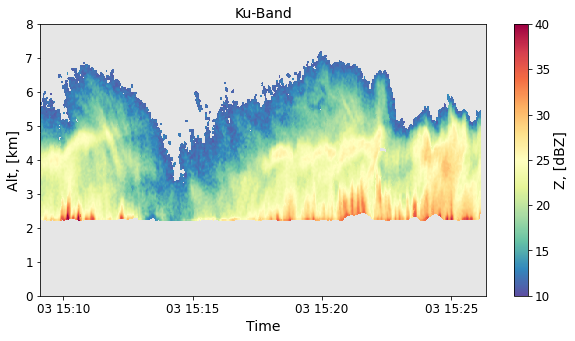

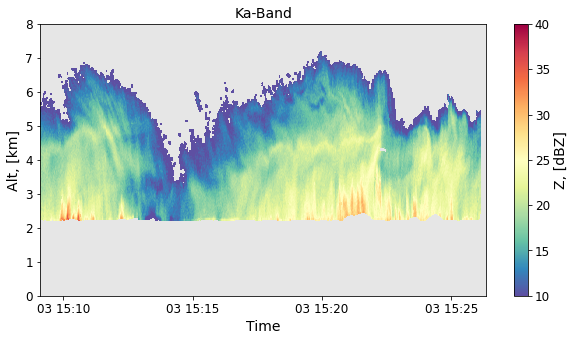

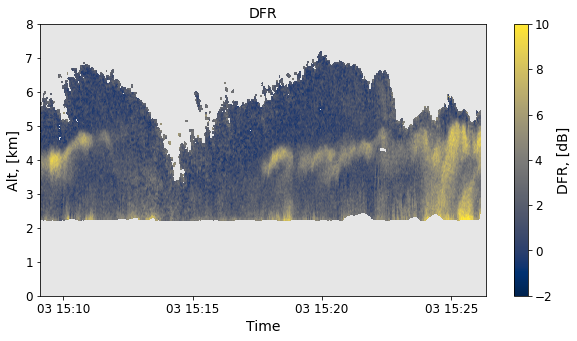

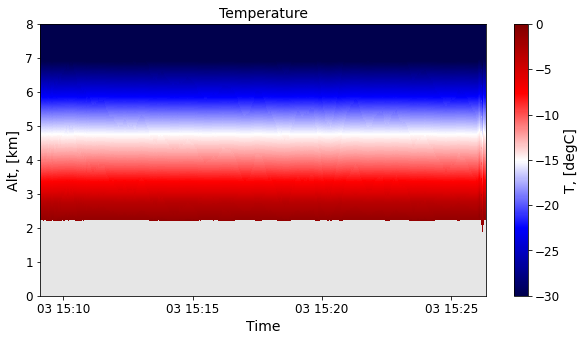

In [39]:
%pylab inline 

#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
#

plt.figure(figsize=(10,5))
plt.pcolormesh(ds['time3d'][:,0,:],ds['alt3d'][:,0,:]/1000.,ds['Ku'][:,0,:],vmin=10,vmax=40,cmap='Spectral_r')
plt.colorbar(label='Z, [dBZ]')
plt.ylim([0,8])
plt.title('Ku-Band')
plt.xlabel('Time')
plt.ylabel('Alt, [km]')

plt.figure(figsize=(10,5))
plt.pcolormesh(ds['time3d'][:,0,:],ds['alt3d'][:,0,:]/1000.,ds['Ka'][:,0,:],vmin=10,vmax=40,cmap='Spectral_r')
plt.colorbar(label='Z, [dBZ]')
plt.ylim([0,8])
plt.title('Ka-Band')
plt.xlabel('Time')
plt.ylabel('Alt, [km]')

plt.figure(figsize=(10,5))
plt.pcolormesh(ds['time3d'][:,0,:],ds['alt3d'][:,0,:]/1000.,ds['Ku'][:,0,:]-ds['Ka'][:,0,:],vmin=-2,vmax=10,cmap='cividis')
plt.colorbar(label='DFR, [dB]')
plt.ylim([0,8])
plt.title('DFR')
plt.xlabel('Time')
plt.ylabel('Alt, [km]')

plt.figure(figsize=(10,5))
plt.pcolormesh(ds['time3d'][:,0,:],ds['alt3d'][:,0,:]/1000.,ds['T3d'][:,0,:],vmin=-30,vmax=0,cmap='seismic')
plt.colorbar(label='T, [degC]')
plt.ylim([0,8])
plt.title('Temperature')
plt.xlabel('Time')
plt.ylabel('Alt, [km]')

### Step 3: Make function to run the retireval. 

Here is an example function of how to run the retrieval. It takes 2d inputs and outputs the retrieved variables in the same 2d shape. 

**Please note the input units!!** 

In [31]:
def run_retrieval(Ku,Ka,T):
    
    """ Main function to actually run the retrieval. 
    
    Inputs:
    =======
    
    Ku:2d np.array, dim = (along_track,range), unit = dBZ
    Ka:2d np.array, dim = (along_track,range), unit = dBZ
    T :2d np.array, dim = (along_track,range), unit= degC
    
    =======
    
    Outputs:
    ========
    
    Dm:2d np.array, dim = (along_track,range), unit = mm, name= liquid eq. mass weighted mean diameter 
    Dm_frozen: 2d np.array, dim = (along_track,range), unit = mm, name= solid phase mass weighted mean diameter  
    Nw: 2d np.array, dim = (along_track,range), unit = log(m^-4), name= liquid eq. normalized intercept parameter  
    IWC: 2d np.array, dim = (along_track,range), unit = g m^{-3}, name= ice water content 
    
    ========
    """
        
    #load packages
    from pickle import load
    import tensorflow as tf

    #load scalers 
    scaler_X = load(open('./Chase_et_al_2021_NN/'+'scaler_X_V2.pkl', 'rb'))
    scaler_y = load(open('./Chase_et_al_2021_NN/'+'scaler_y_V2.pkl', 'rb'))

    #supress warnings. skrews up my progress bar when running in parallel
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn
    #
    
    #load the trained model 
    model = tf.keras.models.load_model('./Chase_et_al_2021_NN/' + 'NN_6by8.h5',custom_objects=None,compile=True)

    #now we have to reshape things to make sure they are in the right shape for the NN model [n_samples,n_features]
    shape_step1 = Ku.shape
    Ku = Ku.reshape([Ku.shape[0]*Ku.shape[1]])
    Ka = Ka.reshape([Ka.shape[0]*Ka.shape[1]])
    T = T.reshape([T.shape[0]*T.shape[1]])
    
    #make sure that Ku and Ka match 
    Ku[np.isnan(Ka)] = np.nan
    Ka[np.isnan(Ku)] = np.nan
    #
    #mask gates with temperatures > 0 
    Ku[T>0] = np.nan
    #mask gates with DFR < -0.5, shouldnt be ever be lower than this (plus/minus Cal uncert.)
    Ku[(Ku-Ka) < -0.5] = np.nan
    
    #Make sure we only run in on non-nan values to save time 
    ind_masked = np.isnan(Ku) 
    ind_masked2 = np.isnan(Ka)
    Ku_nomask = np.zeros(Ku.shape)
    Ka_nomask = np.zeros(Ka.shape)
    T_nomask = np.zeros(T.shape)
    Ku_nomask[~ind_masked] = Ku[~ind_masked]
    Ka_nomask[~ind_masked] = Ka[~ind_masked]
    T_nomask[~ind_masked] = T[~ind_masked]

    ind = np.where(Ku_nomask!=0)[0]

    #scale the input vectors by the mean that it was trained with
    X = np.zeros([Ku_nomask.shape[0],3])
    X[:,0] = (Ku_nomask - scaler_X.mean_[0])/scaler_X.scale_[0] #Ku
    X[:,1] = ((Ku_nomask - Ka_nomask)- scaler_X.mean_[1])/scaler_X.scale_[1] #DFR Ku - Ka
    X[:,2] = (T_nomask - scaler_X.mean_[2])/scaler_X.scale_[2] #T
    #

    #conduct the retrieval 
    yhat = model.predict(X[ind,0:3],batch_size=len(X[ind,0]))
    #scale it properly 
    yhat = scaler_y.inverse_transform(yhat)
    yhat[:,1] = 10**yhat[:,1] #unlog Dm liquid
    yhat[:,2] = 10**yhat[:,2] #unlog Dm solid

    #fill the Nw array 
    ind = np.where(Ku_nomask!=0)[0]
    Nw = np.zeros(Ku_nomask.shape)
    Nw[ind] = np.squeeze(yhat[:,0])
    #reshape it back to input shape
    Nw = Nw.reshape([shape_step1[0],shape_step1[1]])
    Nw[Nw==0.0] = np.nan

    Dm = np.zeros(Ku_nomask.shape)
    Dm[ind] = np.squeeze(yhat[:,1])
    Dm = Dm.reshape([shape_step1[0],shape_step1[1]])
    Dm[Dm==0.0] = np.nan 
    
    Dm_frozen = np.zeros(Ku_nomask.shape)
    Dm_frozen[ind] = np.squeeze(yhat[:,2])
    Dm_frozen = Dm_frozen.reshape([shape_step1[0],shape_step1[1]])
    Dm_frozen[Dm_frozen==0.0] = np.nan

    #calculate IWC 
    Nw = 10**Nw #undo log, should be in m^-4
    Dm = Dm/1000. # convert to m ^4
    IWC = (Nw*(Dm)**4*1000*np.pi)/4**(4) # the 1000 is density of water (kg/m^3)
    IWC = IWC*1000 #convert to g/m^3 
    
    return Dm*1000,Dm_frozen,np.log10(Nw),IWC

In [32]:
Dm_liq,Dm_sol,Nw,IWC = run_retrieval(ds['Ku'].values[:,0,:],ds['Ka'].values[:,0,:],ds['T3d'].values[:,0,:])

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.preprocessing.data module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.preprocessing. Anything that cannot be imported from sklearn.preprocessing is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 0.21.2 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less


### Step 4: Marvel at the accomplishment

Congrats! You ran the neural network! Take a look at the data it output

Text(0, 0.5, 'Alt, [km]')

/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


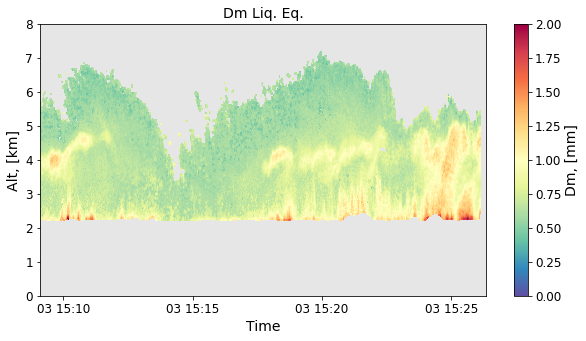

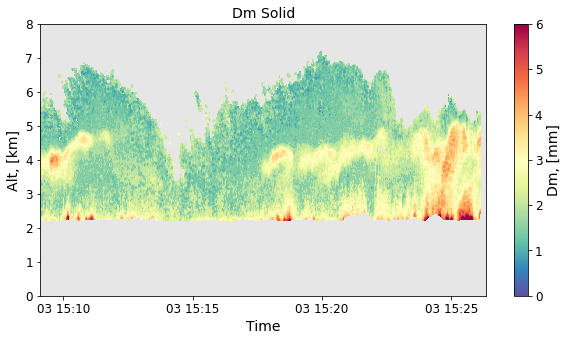

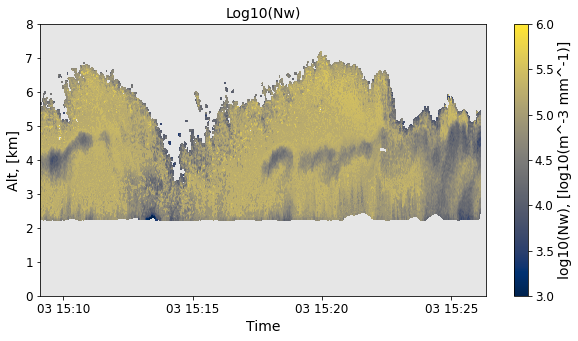

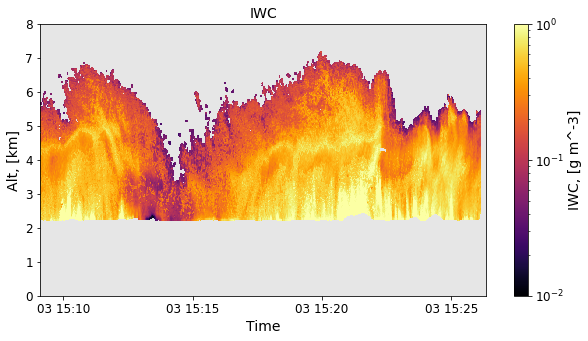

In [40]:
#plot parameters that I personally like, feel free to make these your own.
matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9]
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12
matplotlib.rcParams['legend.facecolor'] = 'w'
#

plt.figure(figsize=(10,5))
plt.pcolormesh(ds['time3d'][:,0,:],ds['alt3d'][:,0,:]/1000.,Dm_liq,vmin=0,vmax=2,cmap='Spectral_r')
plt.colorbar(label='Dm, [mm]')
plt.ylim([0,8])
plt.title('Dm Liq. Eq.')
plt.xlabel('Time')
plt.ylabel('Alt, [km]')

plt.figure(figsize=(10,5))
plt.pcolormesh(ds['time3d'][:,0,:],ds['alt3d'][:,0,:]/1000.,Dm_sol,vmin=0,vmax=6,cmap='Spectral_r')
plt.colorbar(label='Dm, [mm]')
plt.ylim([0,8])
plt.title('Dm Solid')
plt.xlabel('Time')
plt.ylabel('Alt, [km]')

plt.figure(figsize=(10,5))
plt.pcolormesh(ds['time3d'][:,0,:],ds['alt3d'][:,0,:]/1000.,Nw-3,cmap='cividis',vmin=3,vmax=6)
plt.colorbar(label='log10(Nw), [log10(m^-3 mm^-1)]')
plt.ylim([0,8])
plt.title('Log10(Nw)')
plt.xlabel('Time')
plt.ylabel('Alt, [km]')


import matplotlib.colors as colors 

plt.figure(figsize=(10,5))
plt.pcolormesh(ds['time3d'][:,0,:],ds['alt3d'][:,0,:]/1000.,IWC,cmap='inferno',norm=colors.LogNorm(vmin=1e-2, vmax=1))
plt.colorbar(label='IWC, [g m^-3]')
plt.ylim([0,8])
plt.title('IWC')
plt.xlabel('Time')
plt.ylabel('Alt, [km]')

If you have any further questions please email me 